In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from time import time

tf.keras.backend.set_floatx('float32')

class AxialBar1D:
    def __init__(self, L, E, A, q, N=1000, num_hidden_layers=1, num_neurons_per_layer=20, activation='tanh', actual_solution=None, epochs=5000):
        self.L = L
        self.E = E
        self.N = N
        self.epochs = epochs
        self.xmin = 0
        self.xmax = self.L
        self.model = self.initialize_NN(num_hidden_layers, num_neurons_per_layer, activation)
        self.X = self.get_data()
        self.A = A
        self.q = q
        self.learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000, 10000], [1e-2, 1e-4, 5e-5])
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        if actual_solution is not None:
            self.actual_solution = actual_solution
        else:
            self.actual_solution = None

    def get_data(self):
        X = tf.linspace(start=self.xmin, stop=self.xmax, num=self.N)
        X = tf.expand_dims(X, axis=-1)
        X = tf.cast(X, dtype=tf.float32)
        return X

    def initialize_NN(self, num_hidden_layers, num_neurons_per_layer, activation):
        model = tf.keras.Sequential()
        # Add's an input layer with single input neuron
        model.add(tf.keras.Input(1))
        # Add the hidden layers
        for i in range(num_hidden_layers):
            model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=activation, kernel_initializer='glorot_normal'))
        # Add output layer with single output neuron 
        model.add(tf.keras.layers.Dense(1))
        return model

    def psi(self, dudx):
         # Defined potential energy function
        return 0.5 * self.A(self.X) * self.E * (dudx**2)

    #trapezoidal integration function
    def trapz(self, potential_energy, u):
        h = (self.xmax - self.xmin) / self.N
        integrand = potential_energy - self.q(self.X) * u
        integrand1 = integrand[1:]
        integrand0 = integrand[:-1]
        integral = (h / 2) * tf.reduce_sum(integrand1 + integrand0)
        return integral

    def get_loss(self):
        with tf.GradientTape(persistent=True) as tape:
            x = self.X
            x_b = tf.ones((1, 1), dtype=tf.float32) * self.L
            tape.watch(x)
            tape.watch(x_b)

            # Find u (output of the model)
            y = self.model(x)
            u = x * self.model(x)
            dudx = tape.gradient(u, x)
            psi_of_x = self.psi(dudx)

            # Perform trapezoidal integration
            integral = self.trapz(psi_of_x, u)

            # get the boundary loss for the natural boundary condition
            y_b = self.model(x_b)
            u_b = x_b * self.model(x_b)
            dudx_b = tape.gradient(u_b, x_b)

        loss = integral + tf.square(dudx_b)
        return loss

    def get_gradients(self):
        with tf.GradientTape(persistent=True) as tape:
            loss = self.get_loss()

        g = tape.gradient(loss, self.model.trainable_variables)
        del tape
        return loss, g

    def train_step(self):
        # Compute current loss and gradient w.r.t. parameters
        loss, grad_theta = self.get_gradients()
        # Perform gradient descent step
        self.optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
        return loss

    def train(self):
        epochs = self.epochs
        hist = []

        # Start timer
        t0 = time()

        for i in range(epochs+1):
            loss = self.train_step()
            hist.append(loss.numpy())
            if i % 50 == 0:
                print(f'It {i}: loss = {loss.numpy()}')
        # Print computation time
        print('\nComputation time: {} seconds'.format(time() - t0))

        # Get the mean_absolute error
        predictions = self.predict(self.X)
        if self.actual_solution is not None:
            mae = tf.reduce_mean(tf.abs(predictions - self.actual_solution(self.X)))
            mse = tf.reduce_mean(tf.square(predictions - self.actual_solution(self.X)))
        else:
            mae = None
            mse = None
        return {'training_history': hist, 'training_time': time() - t0, 'mae': mae, 'mse': mse}

    def plot_results(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.X)
            predicted_solution = self.X * self.model(self.X)
            predicted_slope = tape.gradient(predicted_solution, self.X)
            plt.figure(figsize=(10, 10))
            plt.plot(self.X, predicted_solution, label='predicted', color='cyan', linewidth=7)
            if self.actual_solution is not None:
                actual_solution = self.actual_solution(self.X)
                actual_slope = tape.gradient(actual_solution, self.X)
                plt.plot(self.X, actual_solution, label='actual', linestyle='dashed', color='red', linewidth=7)
            plt.xlabel("X")
            plt.ylabel("u(X)")
            plt.title("Axial Loading Prediction")
            plt.legend()
            # Plot the slope
            plt.figure(figsize=(10, 10))
            plt.plot(self.X, predicted_slope, label='predicted')
            if self.actual_solution is not None:
                plt.plot(self.X, actual_slope, label='actual')
            plt.xlabel("X")
            plt.ylabel("du(X)/dx")
            plt.title("Axial Loading Prediction Slope")
            plt.legend()
            
    
    def predict(self, X):
        return X * self.model.predict(X)


# Experiment - 1.1

In [42]:
L = 1
E = 1000

def q(X):
  return tf.ones(shape=X.shape)*100

def A(X):
  return tf.ones(shape=X.shape)*2

def actual_solution(X):
  return (q(X)*X/(2*A(X)*E))*(2*L - X)

mymodel = AxialBar1D(L=L,
                   E=E,
                   A=A,
                   q=q,
                   N=1000,
                   actual_solution=actual_solution,
                   epochs = 60000)

mymodel.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                40        
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = mymodel.train()

It 0: loss = [[3.5805242]]
It 50: loss = [[-0.75804275]]
It 100: loss = [[-0.812103]]
It 150: loss = [[-0.82241035]]
It 200: loss = [[-0.82811046]]
It 250: loss = [[-0.8308069]]
It 300: loss = [[-0.8319186]]
It 350: loss = [[-0.8323206]]
It 400: loss = [[-0.8324487]]
It 450: loss = [[-0.83248496]]
It 500: loss = [[-0.8324935]]
It 550: loss = [[-0.8324955]]
It 600: loss = [[-0.8324957]]
It 650: loss = [[-0.8324963]]
It 700: loss = [[-0.83249617]]
It 750: loss = [[-0.83249664]]
It 800: loss = [[-0.8324961]]
It 850: loss = [[-0.8324961]]
It 900: loss = [[-0.83249605]]
It 950: loss = [[-0.83249605]]
It 1000: loss = [[-0.8324964]]
It 1050: loss = [[-0.832496]]
It 1100: loss = [[-0.8324964]]
It 1150: loss = [[-0.8324963]]
It 1200: loss = [[-0.83249617]]
It 1250: loss = [[-0.8324964]]
It 1300: loss = [[-0.83249646]]
It 1350: loss = [[-0.8324672]]
It 1400: loss = [[-0.818891]]
It 1450: loss = [[-0.8324575]]
It 1500: loss = [[-0.83249587]]
It 1550: loss = [[-0.83249664]]
It 1600: loss = [[-0.83

It 11800: loss = [[-0.8324979]]
It 11850: loss = [[-0.8324982]]
It 11900: loss = [[-0.8324981]]
It 11950: loss = [[-0.8324981]]
It 12000: loss = [[-0.83249825]]
It 12050: loss = [[-0.83249795]]
It 12100: loss = [[-0.8324982]]
It 12150: loss = [[-0.8324981]]
It 12200: loss = [[-0.8324981]]
It 12250: loss = [[-0.83249843]]
It 12300: loss = [[-0.83249795]]
It 12350: loss = [[-0.83249813]]
It 12400: loss = [[-0.8324981]]
It 12450: loss = [[-0.83249813]]
It 12500: loss = [[-0.83249795]]
It 12550: loss = [[-0.8324982]]
It 12600: loss = [[-0.832498]]
It 12650: loss = [[-0.8324982]]
It 12700: loss = [[-0.8324981]]
It 12750: loss = [[-0.83249843]]
It 12800: loss = [[-0.8324984]]
It 12850: loss = [[-0.8324982]]
It 12900: loss = [[-0.83249813]]
It 12950: loss = [[-0.8324983]]
It 13000: loss = [[-0.832498]]
It 13050: loss = [[-0.83249843]]
It 13100: loss = [[-0.8324983]]
It 13150: loss = [[-0.8324983]]
It 13200: loss = [[-0.83249855]]
It 13250: loss = [[-0.8324984]]
It 13300: loss = [[-0.83249855]

It 24500: loss = [[-0.8324991]]
It 24550: loss = [[-0.83249766]]
It 24600: loss = [[-0.83249885]]
It 24650: loss = [[-0.8324989]]
It 24700: loss = [[-0.83249885]]
It 24750: loss = [[-0.83249885]]
It 24800: loss = [[-0.8324991]]
It 24850: loss = [[-0.8324991]]
It 24900: loss = [[-0.8324987]]
It 24950: loss = [[-0.83249885]]
It 25000: loss = [[-0.832499]]
It 25050: loss = [[-0.8324959]]
It 25100: loss = [[-0.83249885]]
It 25150: loss = [[-0.8324993]]
It 25200: loss = [[-0.83249867]]
It 25250: loss = [[-0.8324987]]
It 25300: loss = [[-0.8324987]]
It 25350: loss = [[-0.8324984]]
It 25400: loss = [[-0.8324987]]
It 25450: loss = [[-0.8324991]]
It 25500: loss = [[-0.8324991]]
It 25550: loss = [[-0.83249843]]
It 25600: loss = [[-0.8324987]]
It 25650: loss = [[-0.83249867]]
It 25700: loss = [[-0.83249897]]
It 25750: loss = [[-0.8324985]]
It 25800: loss = [[-0.83249885]]
It 25850: loss = [[-0.83249897]]
It 25900: loss = [[-0.83249825]]
It 25950: loss = [[-0.8324991]]
It 26000: loss = [[-0.832499

It 37200: loss = [[-0.83249885]]
It 37250: loss = [[-0.8324989]]
It 37300: loss = [[-0.83249897]]
It 37350: loss = [[-0.83249426]]
It 37400: loss = [[-0.83249915]]
It 37450: loss = [[-0.83249897]]
It 37500: loss = [[-0.8324989]]
It 37550: loss = [[-0.83249885]]
It 37600: loss = [[-0.83249897]]
It 37650: loss = [[-0.83249885]]
It 37700: loss = [[-0.8324991]]
It 37750: loss = [[-0.83249915]]
It 37800: loss = [[-0.83249915]]
It 37850: loss = [[-0.83249915]]
It 37900: loss = [[-0.8324991]]
It 37950: loss = [[-0.8324987]]
It 38000: loss = [[-0.83249694]]
It 38050: loss = [[-0.83249855]]
It 38100: loss = [[-0.8324989]]
It 38150: loss = [[-0.83249867]]
It 38200: loss = [[-0.83249855]]
It 38250: loss = [[-0.8324986]]
It 38300: loss = [[-0.8324991]]
It 38350: loss = [[-0.8324992]]
It 38400: loss = [[-0.83249897]]
It 38450: loss = [[-0.8324983]]
It 38500: loss = [[-0.8324991]]
It 38550: loss = [[-0.8324992]]
It 38600: loss = [[-0.83249867]]
It 38650: loss = [[-0.8324987]]
It 38700: loss = [[-0.8

It 49900: loss = [[-0.8324989]]
It 49950: loss = [[-0.83249766]]
It 50000: loss = [[-0.8324987]]
It 50050: loss = [[-0.8324989]]
It 50100: loss = [[-0.832499]]
It 50150: loss = [[-0.83249867]]
It 50200: loss = [[-0.8324992]]
It 50250: loss = [[-0.83249897]]
It 50300: loss = [[-0.8324983]]
It 50350: loss = [[-0.832499]]
It 50400: loss = [[-0.832499]]
It 50450: loss = [[-0.83249885]]
It 50500: loss = [[-0.8324984]]
It 50550: loss = [[-0.83249897]]
It 50600: loss = [[-0.83249885]]
It 50650: loss = [[-0.8324987]]
It 50700: loss = [[-0.83249915]]
It 50750: loss = [[-0.832499]]
It 50800: loss = [[-0.8324989]]
It 50850: loss = [[-0.832498]]
It 50900: loss = [[-0.832499]]
It 50950: loss = [[-0.8324987]]
It 51000: loss = [[-0.8324991]]
It 51050: loss = [[-0.832499]]
It 51100: loss = [[-0.8324987]]
It 51150: loss = [[-0.83249897]]
It 51200: loss = [[-0.832499]]
It 51250: loss = [[-0.83249915]]
It 51300: loss = [[-0.83249885]]
It 51350: loss = [[-0.83249515]]
It 51400: loss = [[-0.83249885]]
It 5

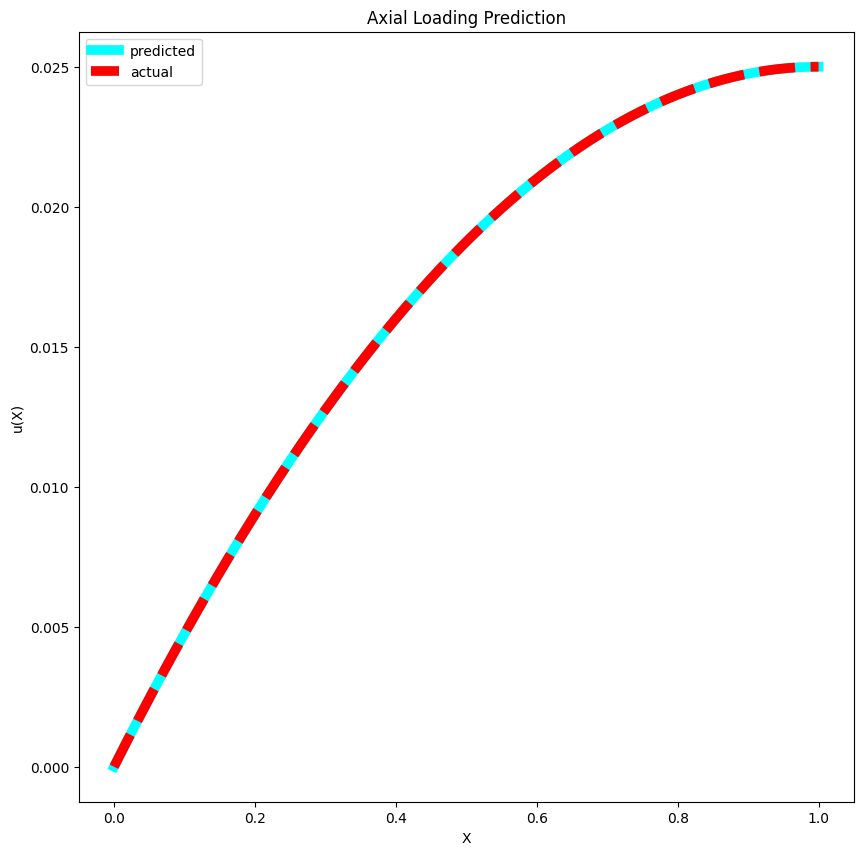

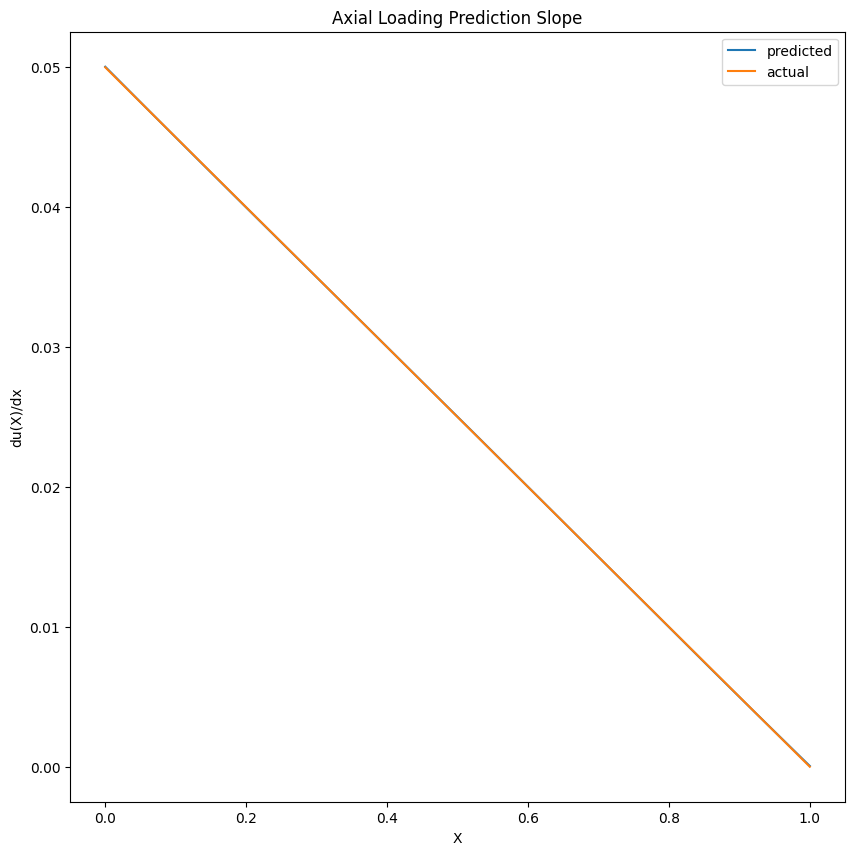

In [44]:
mymodel.plot_results()

In [45]:
training_time = history['training_time']
mae = history['mae']
mse = history['mse']
print(f'Training time: {training_time}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

Training time: 1004.9874849319458
Mean Absolute Error: 1.18764910439495e-06
Mean Squared Error: 1.777686613364804e-12


# Experiment - 1.2

It 0: loss = [[47.864574]]
It 50: loss = [[0.24320163]]
It 100: loss = [[-5.1622587e-06]]
It 150: loss = [[-0.00713434]]
It 200: loss = [[-0.00806182]]
It 250: loss = [[-0.00816649]]
It 300: loss = [[-0.00817727]]
It 350: loss = [[-0.00818191]]
It 400: loss = [[-0.00818656]]
It 450: loss = [[-0.00819137]]
It 500: loss = [[-0.00819641]]
It 550: loss = [[-0.00820156]]
It 600: loss = [[-0.00820676]]
It 650: loss = [[-0.00821202]]
It 700: loss = [[-0.00821731]]
It 750: loss = [[-0.00822259]]
It 800: loss = [[-0.00822788]]
It 850: loss = [[-0.0082331]]
It 900: loss = [[-0.00823823]]
It 950: loss = [[-0.00824327]]
It 1000: loss = [[-0.00824824]]
It 1050: loss = [[-0.00825306]]
It 1100: loss = [[-0.00825776]]
It 1150: loss = [[-0.00826233]]
It 1200: loss = [[-0.00826672]]
It 1250: loss = [[-0.0082709]]
It 1300: loss = [[-0.00827499]]
It 1350: loss = [[-0.00827883]]
It 1400: loss = [[-0.00828252]]
It 1450: loss = [[-0.00828596]]
It 1500: loss = [[-0.00828929]]
It 1550: loss = [[-0.00829239]]
I

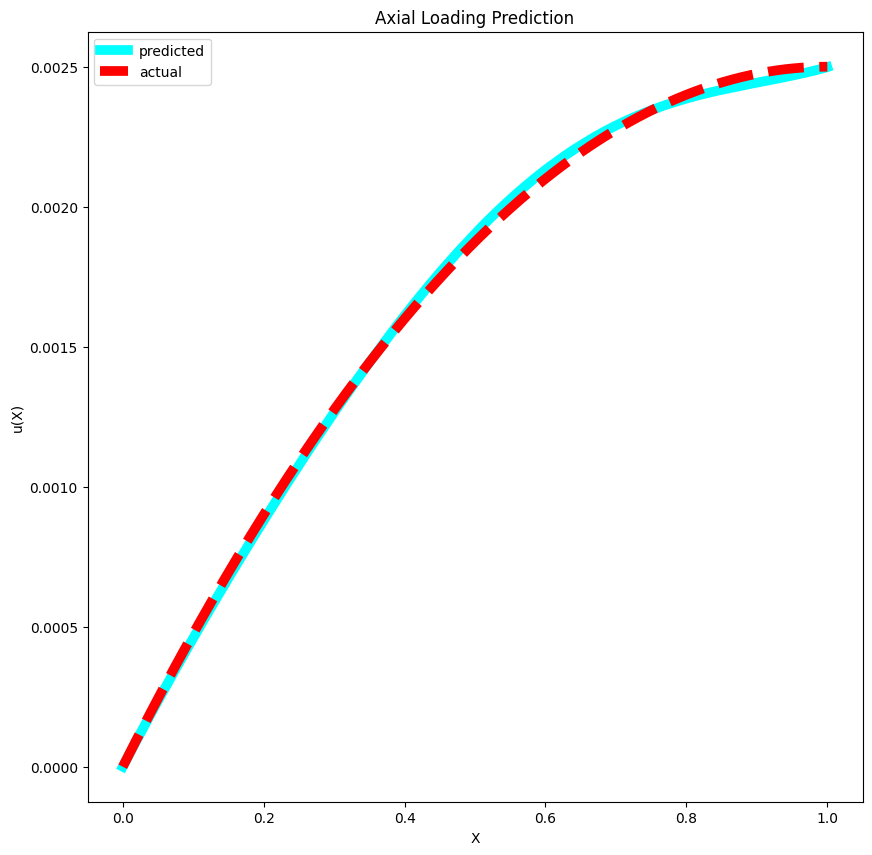

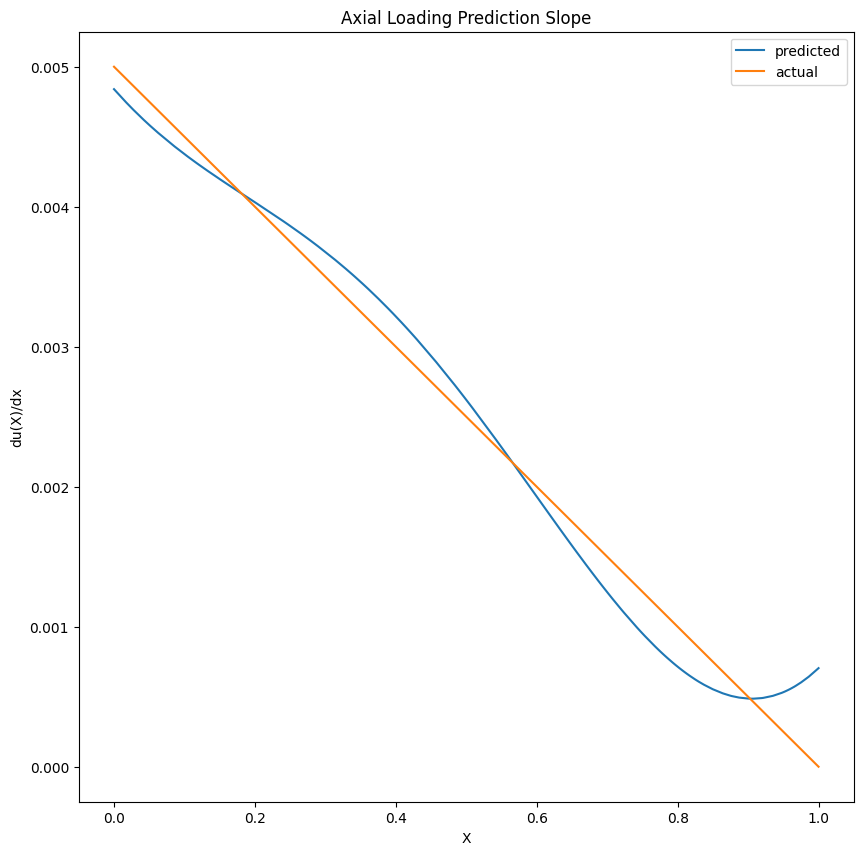

In [46]:
def q(X):
  return tf.ones(shape=X.shape)*10

def A(X):
  return tf.ones(shape=X.shape)*2

def actual_solution(X):
  return (q(X)*X/(2*A(X)*E))*(2*L - X)

# Creating an instance of AxialBar1D
mymodel2 = AxialBar1D(L=L,
                   E=E,
                   A=A,
                   q=q,
                   N=10000,
                   actual_solution=actual_solution,
                   num_hidden_layers=2)

history2 = mymodel2.train()
mymodel2.plot_results()

# Get the training time:
training_time2 = history2['training_time']
mae2 = history2['mae']
mse2 = history2['mse']
print(f'Training time: {training_time2}')
print(f'Mean Absolute Error: {mae2}')
print(f'Mean Squared Error: {mse2}')

# Experiment - 1.3

It 0: loss = [[29.071133]]
It 50: loss = [[1.6564293]]
It 100: loss = [[0.01499398]]
It 150: loss = [[0.00837993]]
It 200: loss = [[0.00619157]]
It 250: loss = [[0.00409435]]
It 300: loss = [[0.00216157]]
It 350: loss = [[0.00042976]]
It 400: loss = [[-0.00108902]]
It 450: loss = [[-0.00239828]]
It 500: loss = [[-0.00351063]]
It 550: loss = [[-0.00444341]]
It 600: loss = [[-0.00521628]]
It 650: loss = [[-0.00584914]]
It 700: loss = [[-0.00636143]]
It 750: loss = [[-0.00677133]]
It 800: loss = [[-0.00709545]]
It 850: loss = [[-0.00734867]]
It 900: loss = [[-0.00754412]]
It 950: loss = [[-0.00769307]]
It 1000: loss = [[-0.00780524]]
It 1050: loss = [[-0.00788864]]
It 1100: loss = [[-0.00794993]]
It 1150: loss = [[-0.00799446]]
It 1200: loss = [[-0.00802652]]
It 1250: loss = [[-0.00804939]]
It 1300: loss = [[-0.00806564]]
It 1350: loss = [[-0.00807721]]
It 1400: loss = [[-0.00808551]]
It 1450: loss = [[-0.00809154]]
It 1500: loss = [[-0.00809609]]
It 1550: loss = [[-0.00809961]]
It 1600: 

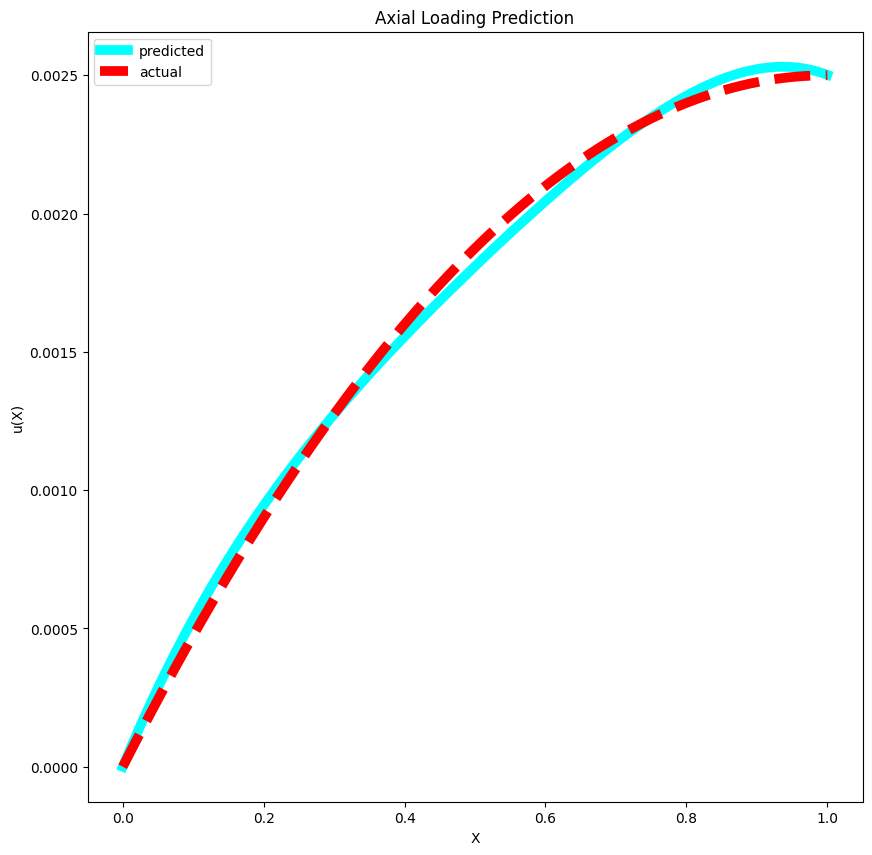

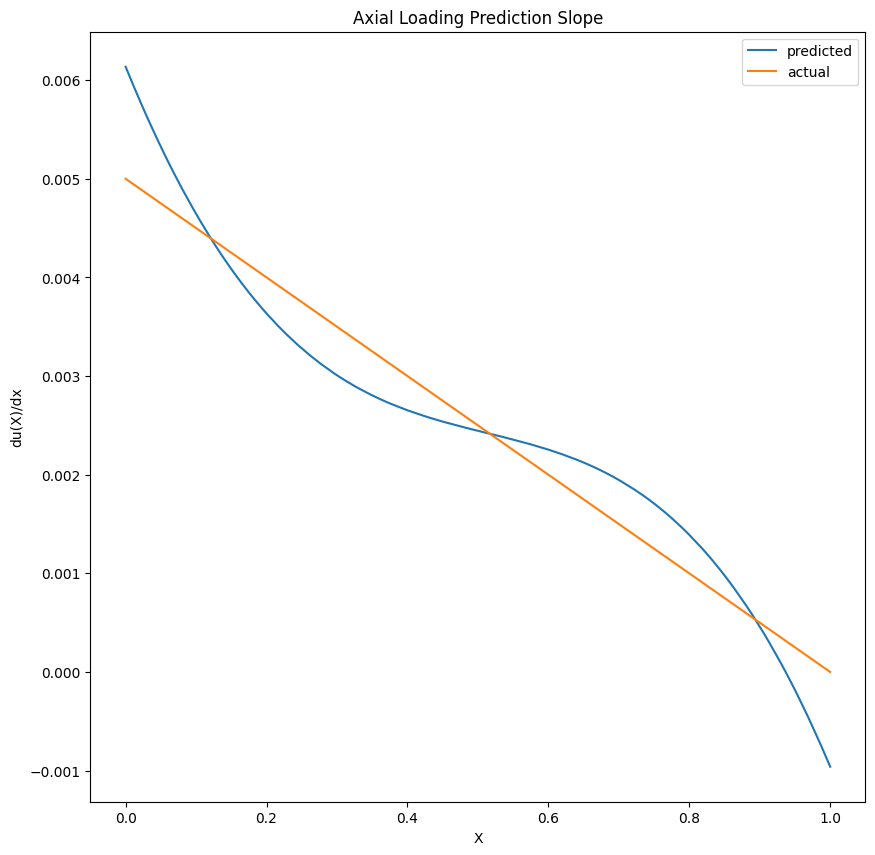

In [47]:
def q(X):
  return tf.ones(shape=X.shape)*10

def A(X):
  return tf.ones(shape=X.shape)*2

def actual_solution(X):
  return (q(X)*X/(2*A(X)*E))*(2*L - X)

mymodel3 = AxialBar1D(L=L,
                   E=E,
                   A=A,
                   q=q,
                   N=10000,
                   actual_solution=actual_solution,
                   num_hidden_layers=2,
                   num_neurons_per_layer=40)
        # Increasing the number of neurons per layer

history3 = mymodel3.train()
mymodel3.plot_results()

# Get the training time:
training_time3 = history3['training_time']
mae3 = history3['mae']
mse3 = history3['mse']
print(f'Training time: {training_time3}')
print(f'Mean Absolute Error: {mae3}')
print(f'Mean Squared Error: {mse3}')

# Experiment - 2

It 0: loss = [[2.6542158]]
It 50: loss = [[-0.96261346]]
It 100: loss = [[-0.96442086]]
It 150: loss = [[-0.9647715]]
It 200: loss = [[-0.9649343]]
It 250: loss = [[-0.9650049]]
It 300: loss = [[-0.9650412]]
It 350: loss = [[-0.96506804]]
It 400: loss = [[-0.96509296]]
It 450: loss = [[-0.9651169]]
It 500: loss = [[-0.9651403]]
It 550: loss = [[-0.9651633]]
It 600: loss = [[-0.9651853]]
It 650: loss = [[-0.9652065]]
It 700: loss = [[-0.965227]]
It 750: loss = [[-0.96524674]]
It 800: loss = [[-0.96526563]]
It 850: loss = [[-0.96528375]]
It 900: loss = [[-0.9653012]]
It 950: loss = [[-0.9653177]]
It 1000: loss = [[-0.9653338]]
It 1050: loss = [[-0.96534926]]
It 1100: loss = [[-0.965364]]
It 1150: loss = [[-0.9653786]]
It 1200: loss = [[-0.96539235]]
It 1250: loss = [[-0.9654056]]
It 1300: loss = [[-0.9654186]]
It 1350: loss = [[-0.96543103]]
It 1400: loss = [[-0.9654433]]
It 1450: loss = [[-0.96545523]]
It 1500: loss = [[-0.9654668]]
It 1550: loss = [[-0.96547806]]
It 1600: loss = [[-0.9

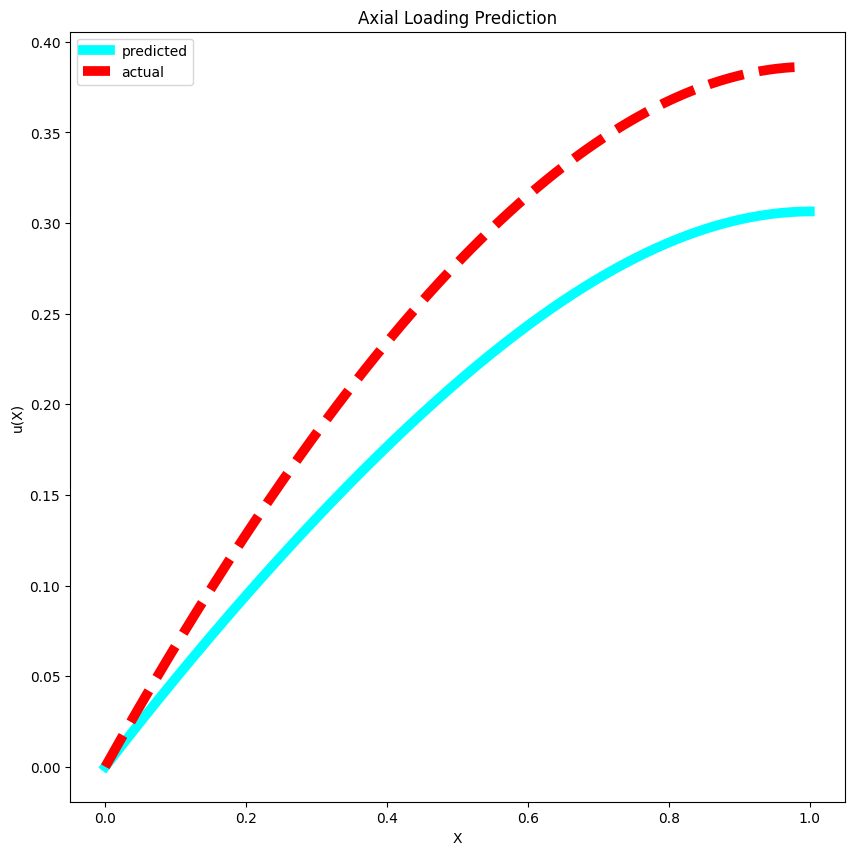

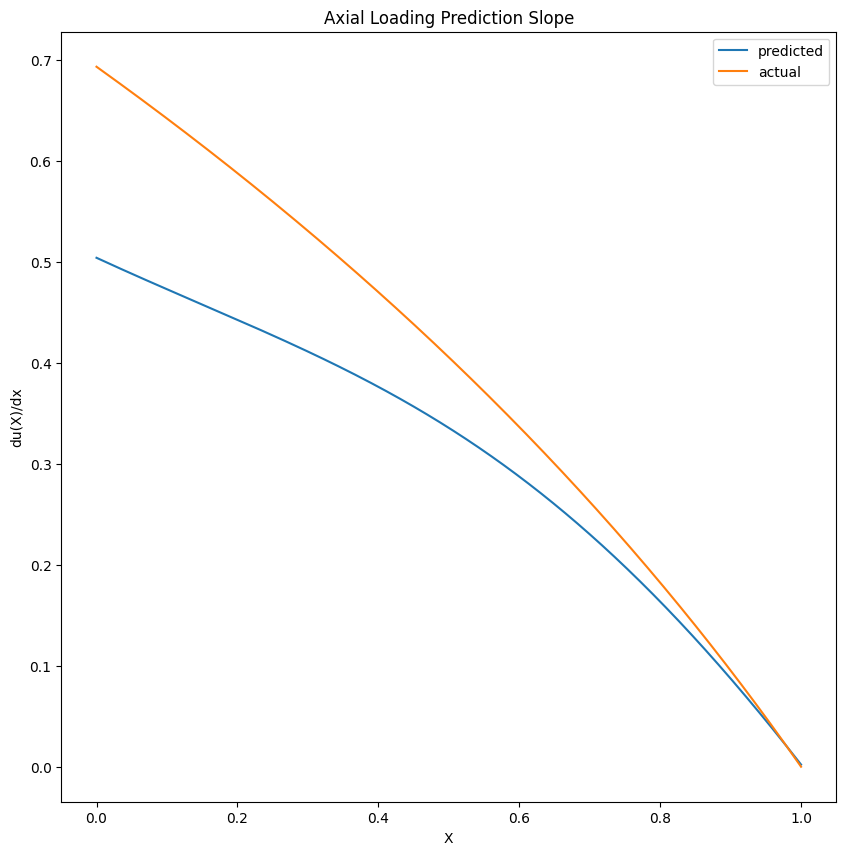

In [48]:

L = 1
E = 10

def q(X):
  return tf.ones(shape=X.shape)*10

def A(X):
  return tf.ones(shape=X.shape)*(1-(X-L)/L)

def actual_solution(X):
  return (q(X)*L*L/E)*(-(2-X/L)*tf.math.log(2-X/L) - X/L + 2*tf.math.log(2.))

mymodel4 = AxialBar1D(L=L,
                   E=E,
                   A=A,
                   q=q,
                   N=10000,
                   actual_solution=actual_solution,
                   num_hidden_layers=2,
                   num_neurons_per_layer=20)

history4 = mymodel4.train()
mymodel4.plot_results()

# Get the training time:
training_time4 = history4['training_time']
mae4 = history4['mae']
mse4 = history4['mse']
print(f'Training time: {training_time4}')
print(f'Mean Absolute Error: {mae4}')
print(f'Mean Squared Error: {mse4}')

It 0: loss = [[1.3261108]]
It 50: loss = [[-0.8179014]]
It 100: loss = [[-0.83322173]]
It 150: loss = [[-0.8332342]]
It 200: loss = [[-0.83323485]]
It 250: loss = [[-0.8332348]]
It 300: loss = [[-0.83323497]]
It 350: loss = [[-0.833235]]
It 400: loss = [[-0.83323497]]
It 450: loss = [[-0.8332352]]
It 500: loss = [[-0.8332352]]
It 550: loss = [[-0.83323514]]
It 600: loss = [[-0.83323544]]
It 650: loss = [[-0.83323544]]
It 700: loss = [[-0.8332355]]
It 750: loss = [[-0.8332357]]
It 800: loss = [[-0.833236]]
It 850: loss = [[-0.83323604]]
It 900: loss = [[-0.83323604]]
It 950: loss = [[-0.8332361]]
It 1000: loss = [[-0.8332363]]
It 1050: loss = [[-0.8332364]]
It 1100: loss = [[-0.83323646]]
It 1150: loss = [[-0.8332365]]
It 1200: loss = [[-0.8332368]]
It 1250: loss = [[-0.8332368]]
It 1300: loss = [[-0.83323693]]
It 1350: loss = [[-0.83323705]]
It 1400: loss = [[-0.83323705]]
It 1450: loss = [[-0.83323747]]
It 1500: loss = [[-0.8332374]]
It 1550: loss = [[-0.83323765]]
It 1600: loss = [[-

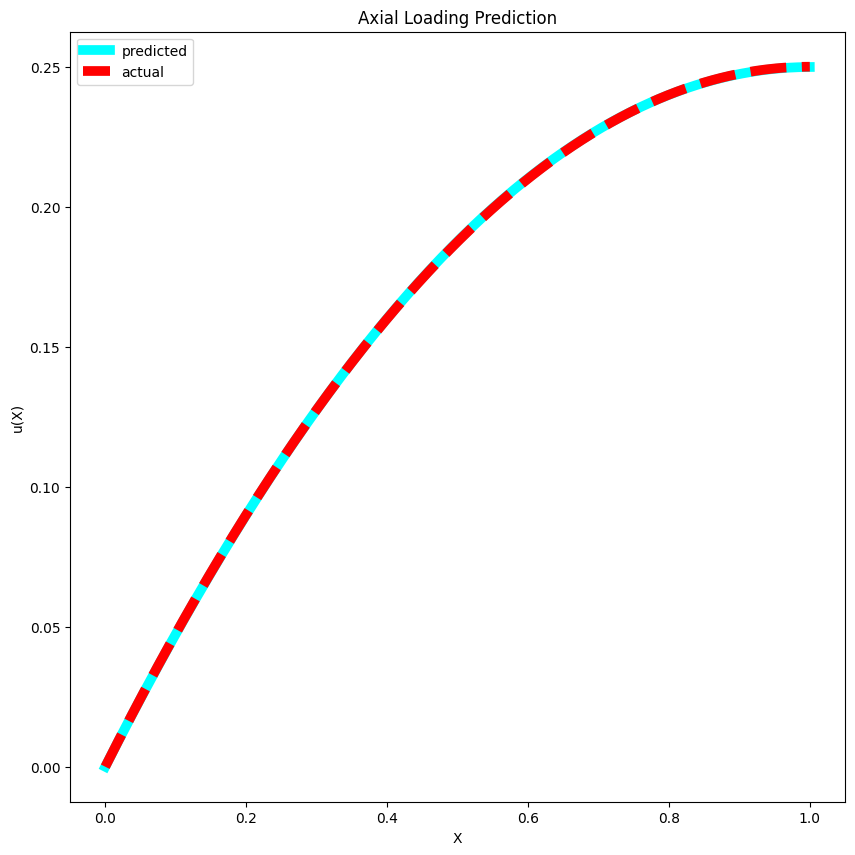

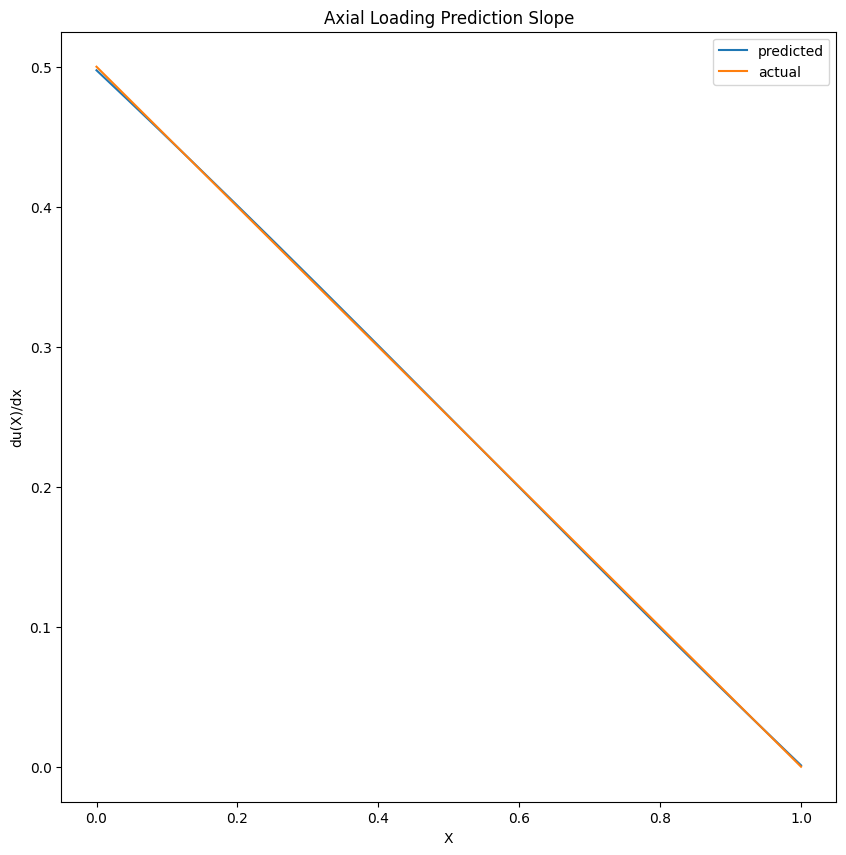

In [49]:
def q(X):
  return tf.ones(shape=X.shape)*10

def A(X):
  return tf.ones(shape=X.shape)*2

def actual_solution(X):
  return (q(X)*X/(2*A(X)*E))*(2*L - X)

mymodel3 = AxialBar1D(L=L,
                   E=E,
                   A=A,
                   q=q,
                   N=10000,
                   actual_solution=actual_solution,
                   num_hidden_layers=3,
                   num_neurons_per_layer=50)

history3 = mymodel3.train()
mymodel3.plot_results()

# Get the training time:
training_time3 = history3['training_time']
mae3 = history3['mae']
mse3 = history3['mse']
print(f'Training time: {training_time3}')
print(f'Mean Absolute Error: {mae3}')
print(f'Mean Squared Error: {mse3}')

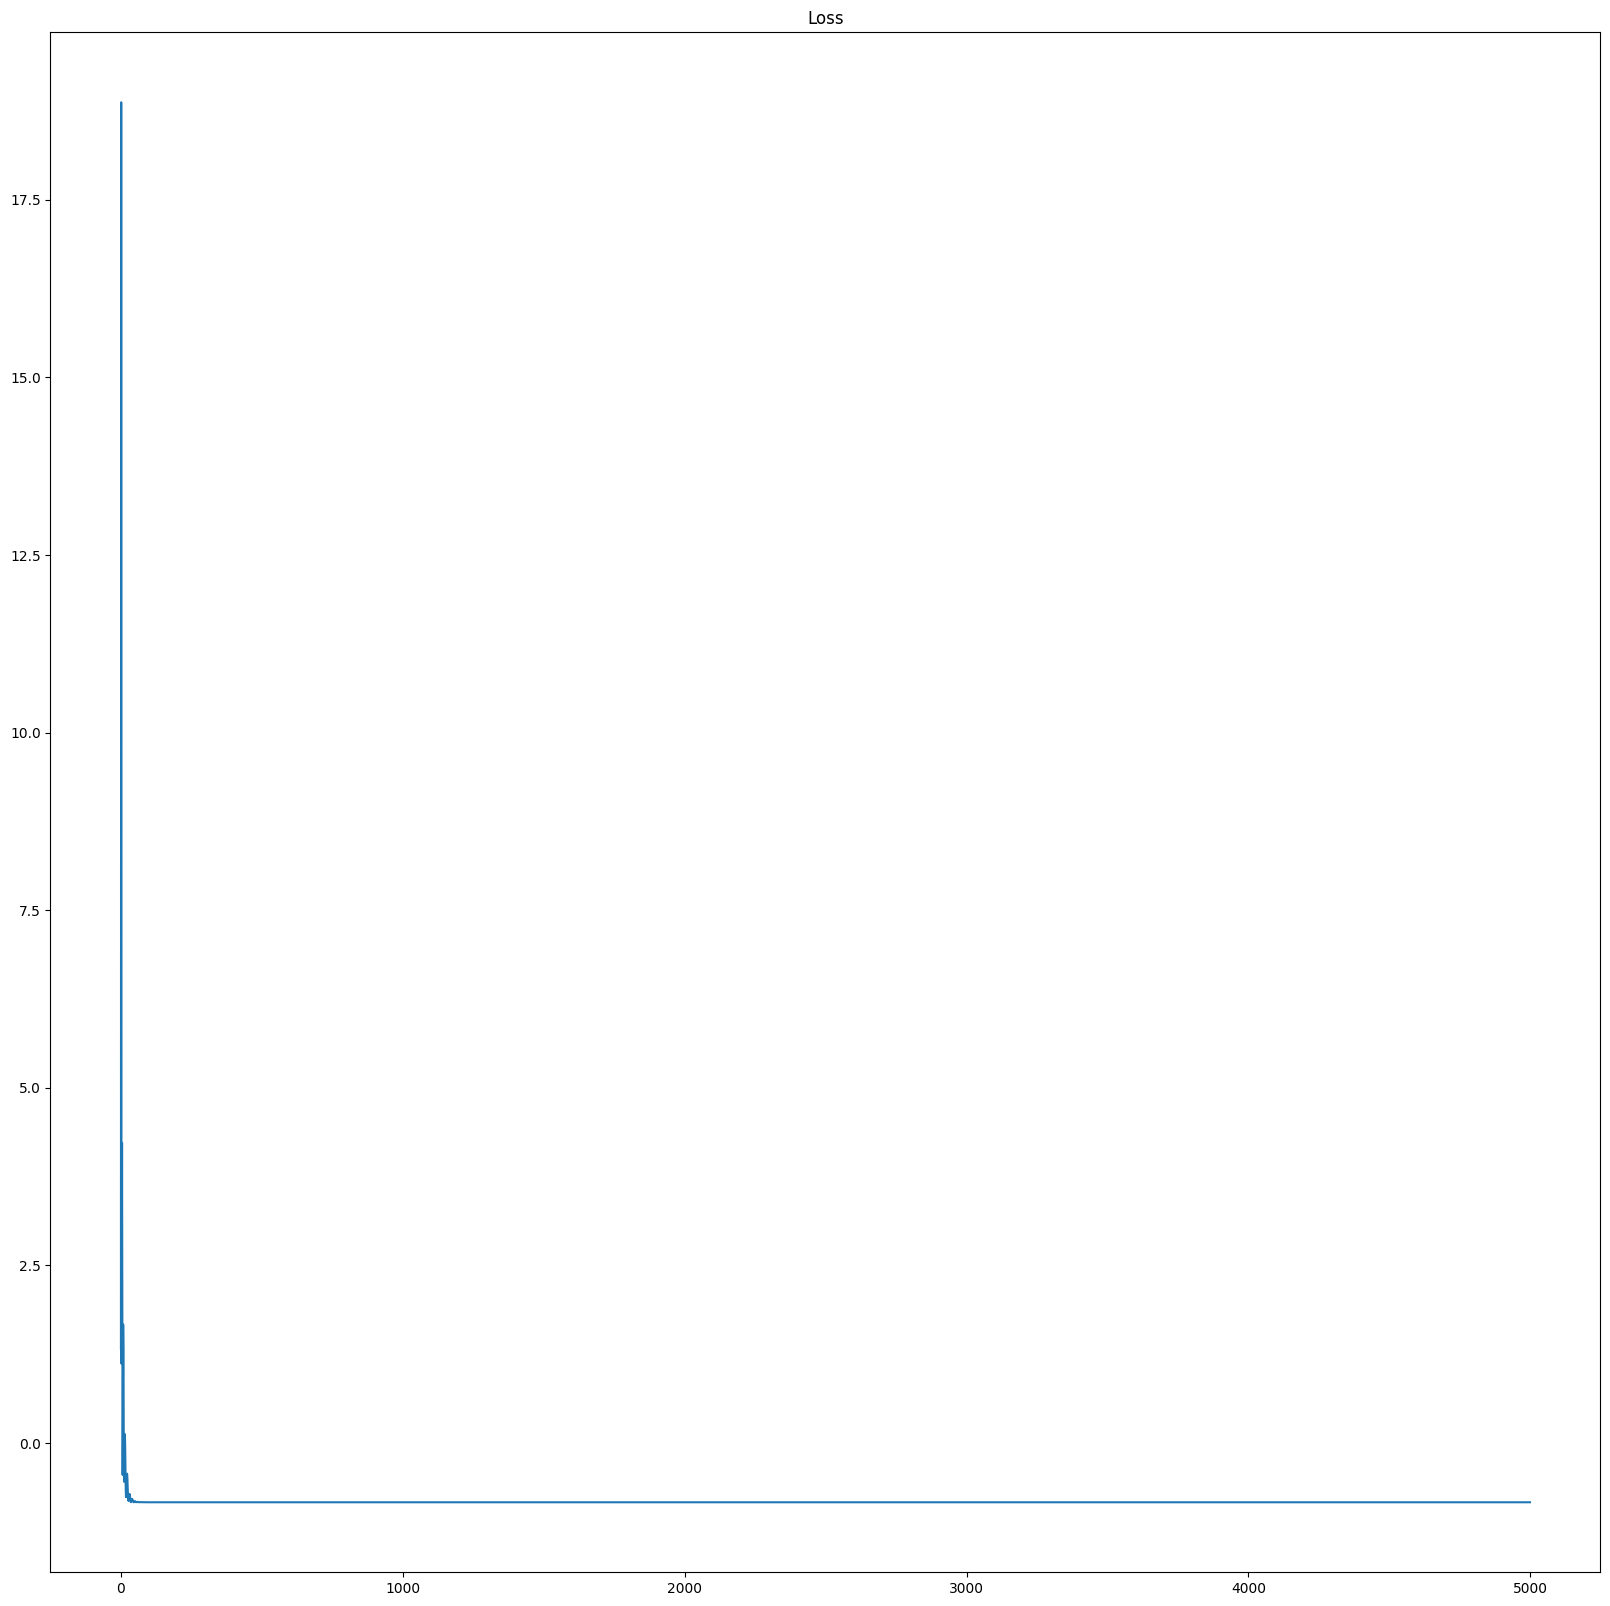

In [50]:
plt.figure(figsize=(20, 20))
plt.plot(range(5000), tf.squeeze(history3['training_history'])[:-1])
plt.title('Training loss over epochs')
plt.show()